In [24]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from operator import itemgetter
import collections
from community import community_louvain
from networkx.algorithms.community.centrality import girvan_newman
import itertools
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.preprocessing import OneHotEncoder
from pandas.plotting import scatter_matrix
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from sklearn.externals import joblib
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
import re
import os
import json
import folium
from datetime import datetime, date, time
import scipy as sp
import warnings
sns.set_context('notebook')
warnings.filterwarnings('ignore')

In [43]:
pokemon=pd.read_csv('Data/'+'pokemon.csv')
combat=pd.read_csv('Data/'+'combats.csv')
pokemon.head(2)

,pid,Name,Class 1,Class 2,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Legendary
0,1,Bulbasaur,Grass,Poison,45,49,49,65,65,45,False
1,2,Ivysaur,Grass,Poison,60,62,63,80,80,60,False


In [26]:
pokemon.describe()

,pid,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed
count,800.0000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000
mean,400.5000,69.258750,79.001250,73.842500,72.820000,71.902500,68.277500
std,231.0844,25.534669,32.457366,31.183501,32.722294,27.828916,29.060474
min,1.0000,1.000000,5.000000,5.000000,10.000000,20.000000,5.000000
25%,200.7500,50.000000,55.000000,50.000000,49.750000,50.000000,45.000000
50%,400.5000,65.000000,75.000000,70.000000,65.000000,70.000000,65.000000
75%,600.2500,80.000000,100.000000,90.000000,95.000000,90.000000,90.000000
max,800.0000,255.000000,190.000000,230.000000,194.000000,230.000000,180.000000


In [27]:
pokemon.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800 entries, 0 to 799
Data columns (total 11 columns):
pid          800 non-null int64
Name         799 non-null object
Class 1      800 non-null object
Class 2      414 non-null object
HP           800 non-null int64
Attack       800 non-null int64
Defense      800 non-null int64
Sp. Atk      800 non-null int64
Sp. Def      800 non-null int64
Speed        800 non-null int64
Legendary    800 non-null bool
dtypes: bool(1), int64(7), object(3)
memory usage: 63.4+ KB


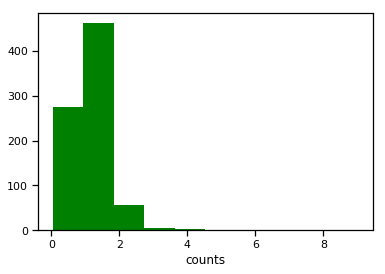

In [28]:
pokemon['ratio']=pokemon.Attack/pokemon.Defense
plt.xlabel('ratio')
plt.xlabel('counts')
_ , _ , _ = plt.hist(pokemon['ratio'],facecolor='green',histtype='stepfilled',stacked=True)
plt.show()

In [29]:
pokemon_ratio=pokemon.sort_values(ascending=False, by='ratio')
pokemon_ratio.reset_index(inplace=True)
pokemon_ratio=pokemon_ratio[['Name','ratio']]
pokemon_ratio.Name.head(10)

0       DeoxysAttack Forme
1                 Carvanha
2            Mega Beedrill
3                 Cranidos
4                 Sharpedo
5      Deoxys Normal Forme
6    Aegislash Blade Forme
7                Rampardos
8            Hoopa Unbound
9                    Pichu
Name: Name, dtype: object

In [30]:
pokemon_ratio.Name.tail(3)

797     Bronzor
798    Magikarp
799     Shuckle
Name: Name, dtype: object

In [31]:
combat.Winner.value_counts(ascending=False)[:10]


163    152
154    136
438    136
428    134
432    133
314    133
214    130
394    130
249    128
155    127
Name: Winner, dtype: int64

In [44]:
win_count=combat.Winner.value_counts()
win_count=pd.DataFrame.from_dict( win_count).reset_index()
win_count=win_count.rename(columns= {'index': 'pid'})
pokemon=pd.merge(pokemon,win_count,on='pid')
pokemon.loc[2:3]

,pid,Name,Class 1,Class 2,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Legendary,Winner
2,3,Venusaur,Grass,Poison,80,82,83,100,100,80,False,89
3,4,Mega Venusaur,Grass,Poison,80,100,123,122,120,80,False,70


In [46]:
first_pokemon_count=combat.First_pokemon.value_counts()
first_pokemon_count=pd.DataFrame.from_dict( first_pokemon_count).reset_index()
first_pokemon_count=first_pokemon_count.rename(columns= {'index': 'pid'})
pokemon=pd.merge(pokemon,first_pokemon_count,on='pid')
second_pokemon_count=combat.Second_pokemon.value_counts()
second_pokemon_count=pd.DataFrame.from_dict( second_pokemon_count).reset_index()
second_pokemon_count=second_pokemon_count.rename(columns= {'index': 'pid'})
pokemon=pd.merge(pokemon,second_pokemon_count,on='pid')
pokemon.loc[2:3]

,pid,Name,Class 1,Class 2,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Legendary,Winner,First_pokemon,Second_pokemon
2,3,Venusaur,Grass,Poison,80,82,83,100,100,80,False,89,68,64
3,4,Mega Venusaur,Grass,Poison,80,100,123,122,120,80,False,70,62,63


In [47]:
pokemon['winning_rate']=pokemon.Winner/(pokemon.First_pokemon+pokemon.Second_pokemon)
pokemon.head(5)

,pid,Name,Class 1,Class 2,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Legendary,Winner,First_pokemon,Second_pokemon,winning_rate
0,1,Bulbasaur,Grass,Poison,45,49,49,65,65,45,False,37,70,63,0.278195
1,2,Ivysaur,Grass,Poison,60,62,63,80,80,60,False,46,55,66,0.380165
2,3,Venusaur,Grass,Poison,80,82,83,100,100,80,False,89,68,64,0.674242
3,4,Mega Venusaur,Grass,Poison,80,100,123,122,120,80,False,70,62,63,0.560000
4,5,Charmander,Fire,NaN,39,52,43,60,50,65,False,55,50,62,0.491071


In [48]:
win_count=combat.Winner.value_counts()
a=pd.DataFrame({'pid':win_count.index,'winning_count':win_count})
a

,pid,winning_count
163,163,152
154,154,136
438,438,136
428,428,134
432,432,133
314,314,133
214,214,130
394,394,130
249,249,128
155,155,127


In [10]:
pokemon_grass_1=pokemon[pokemon['Class 1']=='Grass']
pokemon_grass_2=pokemon[pokemon['Class 2']=='Grass']
pokemon_grass=pokemon_grass_1.append(pokemon_grass_2)
pokemon_grass.Attack.mean()

73.46315789473684

In [11]:
pokemon_rock_1=pokemon[pokemon['Class 1']=='Rock']
pokemon_rock_2=pokemon[pokemon['Class 2']=='Rock']
pokemon_rock=pokemon_rock_1.append(pokemon_rock_2)
pokemon_rock.Attack.mean()

90.72413793103448

In [19]:
from scipy.stats import ttest_ind,ttest_rel
ttest_ind(pokemon_grass.Attack,pokemon_rock.Attack,equal_var=False)

Ttest_indResult(statistic=-3.315895277064196, pvalue=0.0013151441755401136)

In [86]:
pokemon.head(2)

,pid,Name,Class 1,Class 2,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Legendary,ratio,win
0,1,Bulbasaur,Grass,Poison,45,49,49,65,65,45,False,1.000000,0
1,2,Ivysaur,Grass,Poison,60,62,63,80,80,60,False,0.984127,0


In [87]:
combat.head(2)

,First_pokemon,Second_pokemon,Winner
0,266,298,298
1,702,701,701


In [139]:
combat_ml=combat.copy()
combat_ml['first_win']=0
for i in range(len(combat_ml)):
    if combat.First_pokemon[i]==combat.Winner[i]: combat_ml['first_win'][i]=1
combat_ml.head(5)

,First_pokemon,Second_pokemon,Winner,first_win
0,266,298,298,0
1,702,701,701,0
2,191,668,668,0
3,237,683,683,0
4,151,231,151,1


In [140]:
combat_ml = combat_ml.rename(columns= {'First_pokemon': 'pid'})
combat_ml=pd.merge(combat_ml,pokemon)
combat_ml = combat_ml.rename(columns= {'Attack': '1_attack','Defense':'1_defense','Sp. Atk':'1_sp_atk','Sp. Def':'1_sp_def','Speed':'1_speed'
                                      ,'Legendary':'1_led','HP':'1_hp','Class 1':'1_c1','Class 2':'1_c2'})
combat_ml=combat_ml[['Second_pokemon','1_hp','1_attack','1_defense','1_speed','1_led','1_sp_atk','1_sp_def','1_c1','1_c2','first_win']]
combat_ml.head(5)

,Second_pokemon,1_hp,1_attack,1_defense,1_speed,1_led,1_sp_atk,1_sp_def,1_c1,1_c2,first_win
0,298,50,64,50,41,False,45,50,Rock,Ground,0
1,301,50,64,50,41,False,45,50,Rock,Ground,0
2,304,50,64,50,41,False,45,50,Rock,Ground,1
3,247,50,64,50,41,False,45,50,Rock,Ground,0
4,690,50,64,50,41,False,45,50,Rock,Ground,0


In [141]:
combat_ml = combat_ml.rename(columns= {'Second_pokemon': 'pid'})
combat_ml=pd.merge(combat_ml,pokemon)
combat_ml = combat_ml.rename(columns= {'Attack': '2_attack','Defense':'2_defense','Sp. Atk':'2_sp_atk','Sp. Def':'2_sp_def','Speed':'2_speed'
                                      ,'Legendary':'2_led','HP':'2_hp','Class 1':'2_c1','Class 2':'2_c2'})
combat_ml=combat_ml[['1_hp','1_attack','1_defense','1_speed','1_led','1_sp_atk','1_sp_def','1_c1','1_c2',
                     '2_hp','2_attack','2_defense','2_speed','2_led','2_sp_atk','2_sp_def','2_c1','2_c2',
                     'first_win']]
combat_ml.head(5)

,1_hp,1_attack,1_defense,1_speed,1_led,1_sp_atk,1_sp_def,1_c1,1_c2,2_hp,2_attack,2_defense,2_speed,2_led,2_sp_atk,2_sp_def,2_c1,2_c2,first_win
0,50,64,50,41,False,45,50,Rock,Ground,70,70,40,60,False,60,40,Grass,Dark,0
1,70,80,50,35,False,35,35,Fighting,NaN,70,70,40,60,False,60,40,Grass,Dark,0
2,110,78,73,60,False,76,71,Water,Ground,70,70,40,60,False,60,40,Grass,Dark,0
3,50,65,107,86,False,105,107,Electric,Flying,70,70,40,60,False,60,40,Grass,Dark,1
4,73,115,60,90,False,60,60,Normal,NaN,70,70,40,60,False,60,40,Grass,Dark,1


In [143]:
combat_features=combat_ml[['1_hp','1_attack','1_defense','1_speed','1_led','1_sp_atk','1_sp_def','1_c1','1_c2',
                     '2_hp','2_attack','2_defense','2_speed','2_led','2_sp_atk','2_sp_def','2_c1','2_c2']]
combat_labels=combat_ml[['first_win']]

In [144]:
combat_features=pd.get_dummies(combat_features)

In [148]:
x_len=len(combat_ml)
train_features= combat_features[:round( 0.9 * x_len )]
test_features = combat_features[round( 0.9 * x_len ):]
train_labels= combat_labels[:round( 0.9 * x_len )]
test_labels=combat_labels[round( 0.9 * x_len ):]

In [150]:
for temp_col in train_features.columns:
    temp_mean=train_features[temp_col].mean()
    temp_std=train_features[temp_col].std()
    train_features[temp_col]=(train_features[temp_col]-temp_mean)/temp_std
    test_features[temp_col]=(test_features[temp_col]-temp_mean)/temp_std
train_features.head(1)

,1_hp,1_attack,1_defense,1_speed,1_led,1_sp_atk,1_sp_def,2_hp,2_attack,2_defense,...,2_c2_Ghost,2_c2_Grass,2_c2_Ground,2_c2_Ice,2_c2_Normal,2_c2_Poison,2_c2_Psychic,2_c2_Rock,2_c2_Steel,2_c2_Water
0,-0.751267,-0.459349,-0.765467,-0.9256,-0.298118,-0.852985,-0.78998,0.053493,-0.270658,-1.089442,...,-0.112962,-0.173225,-0.210937,-0.130276,-0.073378,-0.195584,-0.210822,-0.131243,-0.169237,-0.124787


In [154]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score  

In [151]:
n_estimators_range=[10,25,50,100]
max_depth_range= [2,4,10]
ne_score=pd.DataFrame({'n_estimators':np.array(n_estimators_range),'acc':0.0})
mp_score=pd.DataFrame({'max_depth':np.array(max_depth_range),'acc':0.0})
rfr_score= pd.merge(ne_score, mp_score)
rfr_score= rfr_score[['n_estimators','max_depth','acc']]

In [157]:
for i in range(len(rfr_score)):
    score_sum=0
    temp_ne= rfr_score['n_estimators'].values[i]
    temp_mp= rfr_score['max_depth'].values[i]
    rfr = RandomForestClassifier(n_estimators= temp_ne, max_depth= temp_mp)
    rfr.fit(train_features, train_labels)
    pred = rfr.predict(train_features)
    acc=accuracy_score(pred,train_labels)
    rfr_score['acc'].values[i]= acc

In [159]:
rfr_score

,n_estimators,max_depth,acc
0,10,2,0.758978
1,10,4,0.787289
2,10,10,0.907333
3,25,2,0.760022
4,25,4,0.800422
5,25,10,0.913600
6,50,2,0.771356
7,50,4,0.834178
8,50,10,0.913311
9,100,2,0.766022


In [160]:
rfr = RandomForestClassifier(n_estimators= 100, max_depth= 10)
rfr.fit(train_features, train_labels)
pred = rfr.predict(test_features)
acc=accuracy_score(pred,test_labels)
acc

0.901

In [162]:
def build_k_indices(y, k_fold, seed):
    """build k indices for k-fold."""
    num_row = y.shape[0]
    interval = int(num_row / k_fold)
    np.random.seed(seed)
    indices = np.random.permutation(num_row)
    k_indices = [indices[k * interval: (k + 1) * interval] for k in range(k_fold)]
    return np.array(k_indices)

In [163]:
n_estimators_range=[10,25,50,100]
max_depth_range= [2,4,10]
ne_score=pd.DataFrame({'n_estimators':np.array(n_estimators_range),'acc':0.0})
mp_score=pd.DataFrame({'max_depth':np.array(max_depth_range),'acc':0.0})
rfr_score= pd.merge(ne_score, mp_score)
rfr_score= rfr_score[['n_estimators','max_depth','acc']]

In [164]:
k_indices=build_k_indices(train_labels,5,6)
for i in range(len(rfr_score)):
    score_sum=0
    temp_ne= rfr_score['n_estimators'].values[i]
    temp_mp= rfr_score['max_depth'].values[i]
    for k in range(5):
        temp_test_indice = k_indices[k]
        temp_train_indice = k_indices[~(np.arange(k_indices.shape[0]) == k)]
        temp_train_indice = temp_train_indice.reshape(-1)
        temp_train_features= train_features.values[temp_train_indice]
        temp_train_labels=train_labels.values[temp_train_indice]
        temp_test_features=train_features.values[temp_test_indice] 
        temp_test_labels=train_labels.values[temp_test_indice]
        
        rfr = RandomForestClassifier(n_estimators= temp_ne, max_depth= temp_mp)
        rfr.fit(temp_train_features, temp_train_labels)
        temp_pred = rfr.predict(temp_test_features)
        temp_score=accuracy_score(temp_pred, temp_test_labels)   
        score_sum=score_sum+temp_score
    temp_acc= score_sum/5
    rfr_score['acc'].values[i]= temp_acc
rfr_score.head(2)

,n_estimators,max_depth,acc
0,10,2,0.742333
1,10,4,0.793933


In [165]:
from sklearn.feature_selection import SelectFromModel
rfr=RandomForestClassifier(n_estimators= 100, max_depth= 10)
ff=rfr.fit(train_features,train_labels)
ff.feature_importances_ 

array([2.44723668e-02, 4.98959440e-02, 1.60631631e-02, 2.96363267e-01,
       1.22073414e-02, 4.02864020e-02, 2.18241209e-02, 2.41393090e-02,
       4.48701744e-02, 1.49542513e-02, 2.90014311e-01, 9.17795945e-03,
       4.33241729e-02, 2.65947581e-02, 1.35678654e-03, 1.29182373e-03,
       8.16016035e-04, 2.21382854e-03, 6.96585200e-04, 6.42740108e-04,
       8.21885856e-04, 3.61680382e-04, 7.82315303e-04, 8.71905988e-04,
       8.30682280e-04, 5.02359377e-04, 1.88006224e-03, 6.13220298e-04,
       1.55586252e-03, 1.25746992e-03, 1.09577743e-03, 1.32126681e-03,
       1.55509650e-04, 6.71912426e-04, 3.67367486e-04, 2.80053131e-04,
       5.83867930e-04, 1.83475834e-03, 3.38023694e-04, 1.17569877e-02,
       3.71371957e-03, 4.25818173e-04, 1.20105306e-03, 4.78385268e-04,
       2.26414631e-04, 5.74012431e-04, 5.95043305e-04, 1.21242354e-03,
       5.24805417e-04, 3.98581666e-04, 1.17643429e-03, 1.70931456e-03,
       4.93024388e-04, 2.37518746e-03, 1.45308698e-03, 3.74064452e-04,
      

In [169]:
importance=ff.feature_importances_ 
importance_bar=pd.DataFrame({'feature':np.array(combat_features.columns),'importance':importance})

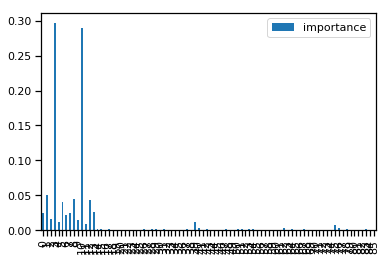

In [171]:
importance_bar.plot.bar()

In [178]:
importance_bar.sort_values(ascending=False, by='importance').head(10)

,feature,importance
3,1_speed,0.296363
10,2_speed,0.290014
1,1_attack,0.049896
8,2_attack,0.044870
12,2_sp_atk,0.043324
5,1_sp_atk,0.040286
13,2_sp_def,0.026595
0,1_hp,0.024472
7,2_hp,0.024139
6,1_sp_def,0.021824


In [180]:
combat.head(1)

,First_pokemon,Second_pokemon,Winner
0,266,298,298


In [228]:
pokemon['winning_rate']=0.0
for i in range(len(pokemon)):
    pid=i+1
    try:
        combat_count=combat.First_pokemon.value_counts()[pid]+combat.Second_pokemon.value_counts()[pid]
        winner_count=combat.Winner.value_counts()[pid]
        temp_winning_rate=winner_count/combat_count
        pokemon['winning_rate'].values[i]=temp_winning_rate
    except:
        pokemon['winning_rate'].values[i]=0

pokemon.head()

,pid,Name,Class 1,Class 2,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Legendary,winning_rate
0,1,Bulbasaur,Grass,Poison,45,49,49,65,65,45,False,0.278195
1,2,Ivysaur,Grass,Poison,60,62,63,80,80,60,False,0.380165
2,3,Venusaur,Grass,Poison,80,82,83,100,100,80,False,0.674242
3,4,Mega Venusaur,Grass,Poison,80,100,123,122,120,80,False,0.560000
4,5,Charmander,Fire,NaN,39,52,43,60,50,65,False,0.491071


In [234]:
g=np.zeros((800,800))
for i in range(800):
    for j in range(800):
        if pokemon.winning_rate.values[i]>=pokemon.winning_rate.values[j]:
            g[i][j]=1
g

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 1., 0., ..., 0., 0., 0.],
       [1., 1., 1., ..., 1., 1., 1.],
       ...,
       [1., 1., 0., ..., 1., 0., 0.],
       [1., 1., 0., ..., 1., 1., 0.],
       [1., 1., 0., ..., 1., 1., 1.]])

In [235]:
a=g+np.dot(g,g)

In [236]:
a

array([[  3.,   0.,   0., ...,   0.,   0.,   0.],
       [106.,   2.,   0., ...,   0.,   0.,   0.],
       [374., 270.,   2., ..., 157.,  56.,  53.],
       ...,
       [219., 115.,   0., ...,   2.,   0.,   0.],
       [320., 216.,   0., ..., 103.,   2.,   0.],
       [323., 219.,   0., ..., 106.,   5.,   2.]])

In [237]:
pokemon['dominance']=0
for i in range(800):
    temp_dom=0
    for j in range(800):
        temp_dom=temp_dom+a[i][j]
    pokemon.dominance.values[i]=temp_dom

In [241]:
pokemon.sort_values(ascending=False, by='dominance')

,pid,Name,Class 1,Class 2,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Legendary,winning_rate,dominance
154,155,Mega Aerodactyl,Rock,Flying,80,135,85,70,95,150,False,0.984496,321435
512,513,Weavile,Dark,Ice,70,120,65,45,85,125,False,0.974790,320634
703,704,Tornadus Therian Forme,Flying,NaN,79,100,80,110,90,121,True,0.968000,319834
19,20,Mega Beedrill,Bug,Poison,65,150,40,15,80,145,False,0.966387,319035
153,154,Aerodactyl,Rock,Flying,80,105,65,60,75,130,False,0.964539,318237
476,477,Mega Lopunny,Normal,Fighting,65,136,94,54,96,135,False,0.961240,317440
726,727,Greninja,Water,Dark,72,95,67,103,71,122,False,0.960630,316644
716,717,Meloetta Pirouette Forme,Normal,Fighting,100,128,90,77,77,128,False,0.959350,315849
164,165,Mega Mewtwo Y,Psychic,NaN,106,150,70,194,120,140,True,0.952000,315055
349,350,Mega Sharpedo,Water,Dark,70,140,70,110,65,105,False,0.950000,314262


In [244]:
import scipy as sp
r, p = sp.stats.pearsonr(pokemon['winning_rate'], pokemon['dominance'])
print("Pearson's correlation coefficient: " + str(r) + "\n2-tailed p-value: " + str(p))

Pearson's correlation coefficient: 0.973030826530783
2-tailed p-value: 0.0
